# replicating v2 of fastai & experimenting with Ranger
# SXRESNET

In [1]:
from fastai.script import *
from fastai.vision import *
from torchvision.models import *
from sxresnet import *

In [2]:
from ranger import *
from annealing import *

In [3]:
torch.cuda.set_device(0)

In [4]:
path = untar_data(URLs.IMAGENETTE_160)
path.ls()

[WindowsPath('C:/Users/dmber/.fastai/data/imagenette-160/models'),
 WindowsPath('C:/Users/dmber/.fastai/data/imagenette-160/train'),
 WindowsPath('C:/Users/dmber/.fastai/data/imagenette-160/val')]

In [5]:
bs = 64
size = 128
data = (ImageList.from_folder(path)
                .split_by_folder(valid='val')
                .label_from_folder()
                .transform(([flip_lr(p=0.5)], []), size=size)
                .databunch(bs=bs, num_workers=1)
                .normalize(imagenet_stats))

In [6]:
# hyper parameters
lr = 4e-3        # learning rate
alpha = 0.99     # alpha
mom = 0.95       # momentum
eps = 1e-6       # epsilon
epochs = 5       # number of epochs
mixup = 0        # mixup
sa = 1           # self attention
sym = 0          # symmetry for attention
ann_start = 0.72 # mixup

# updating lr based on batchsize: will change based on GPU present or not
bs_one_gpu = bs
bs_rat = bs / bs_one_gpu
lr *= bs_rat

In [7]:
# optimization, loss
opt_func = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = LabelSmoothingCrossEntropy()

In [8]:
# our arch
# we will be using a xresnet with mish activation
m = sxresnet34

In [9]:
# creating our learner
learn = (Learner(data,                          # databunch
                 m(c_out=10, sa=sa, sym=sym),   # model parameters
                 wd=1e-2,                       # weight decay
                 opt_func=opt_func,             # optimization: ranger
                 metrics=[accuracy],            # printed metrics
                 bn_wd=False, true_wd=True,     # batch norm
                 loss_func=loss_func)           # loss function: LabelCrossEntropy
        )

# adding mixup:
if mixup > 0.:
    learn.mixup(alpha=alpha);
# adding mixed precision for training
learn.to_fp16();

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


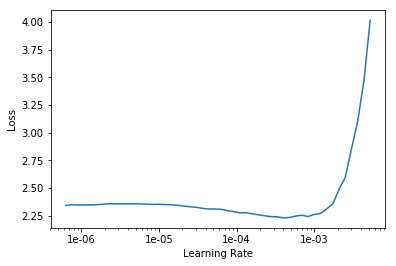

In [10]:
# finding an optimal learning rate
learn.lr_find(wd=1e-2)
learn.recorder.plot()

In [10]:
torch.cuda.empty_cache()

In [10]:
# learning rate seems fine: lets train!
# we will train with flat and anneal
lr = 1e-4
# fit_with_annealing(learn, epochs, lr, ann_start)
learn.fit_one_cycle(epochs, lr, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,1.825199,1.689014,0.470000,01:27
1,2.121340,2.380554,0.100000,01:21
2,2.321432,2.309475,0.100000,01:21
3,2.309410,2.312966,0.100000,01:21
4,2.304097,2.303273,0.100000,01:22


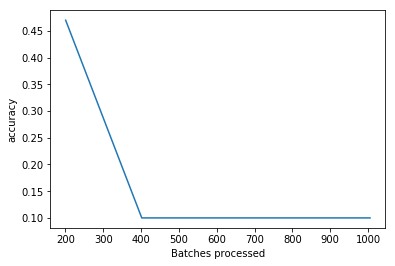

In [11]:
learn.recorder.plot_metrics()

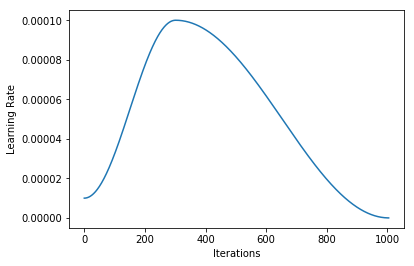

In [12]:
learn.recorder.plot_lr()

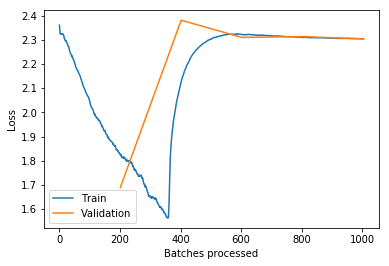

In [13]:
learn.recorder.plot_losses()